In [1]:
!git clone https://github.com/truth771/e2e-sae.git

Cloning into 'e2e-sae'...
remote: Enumerating objects: 359, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 359 (delta 30), reused 27 (delta 12), pack-reused 304 (from 1)
Receiving objects: 100% (359/359), 243.85 KiB | 3.69 MiB/s, done.
Resolving deltas: 100% (228/228), done.


In [2]:
%cd e2e-sae

/content/e2e-sae


In [ ]:
!git restore . && git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 391 bytes | 391.00 KiB/s, done.
From https://github.com/truth771/e2e-sae
   6671b40..fd20b3b  main       -> origin/main
Updating 6671b40..fd20b3b
Fast-forward
 sae/eval/plots.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [3]:
!pip install fairscale

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl size=332208 sha256=18954c2aac0333875b09996213ce723de875ff803b82d23974be141d06739b9f
  Stored in directory: /root/.cache/pip/wheels/5a/88/aa/d84b2cf1bad6b273cbf661640141a82c7b9f496e024f80aac0
Successfully built fairscale


In [4]:
!ls gpt2-pytorch_model.bin || curl --output gpt2-pytorch_model.bin https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-pytorch_model.bin

ls: cannot access 'gpt2-pytorch_model.bin': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  522M  100  522M    0     0  49.0M      0  0:00:10  0:00:10 --:--:-- 49.3M


### Plot generation

In [5]:
from sae.models import SAEParams
from sae.eval import plots
from sae.training.datasets import get_openwebtext_dataloaders, OpenWebTextConfig

In [6]:
train_loader, val_loader = get_openwebtext_dataloaders(OpenWebTextConfig(), 4)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1106 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1086 > 1024). Running this sequence through the model will result in indexing errors


epoch 1: 100%|██████████| 2429/2429 [16:16<00:00,  2.49it/s]


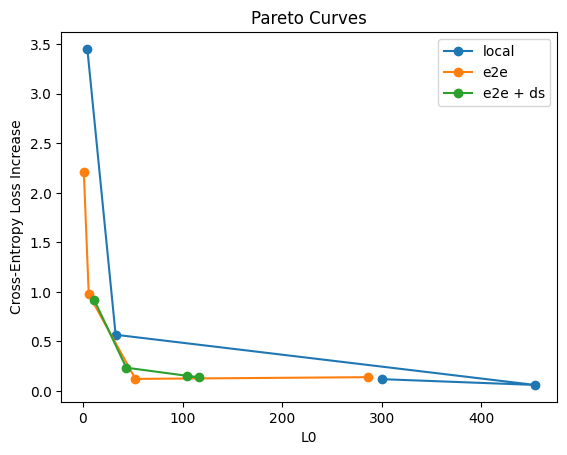

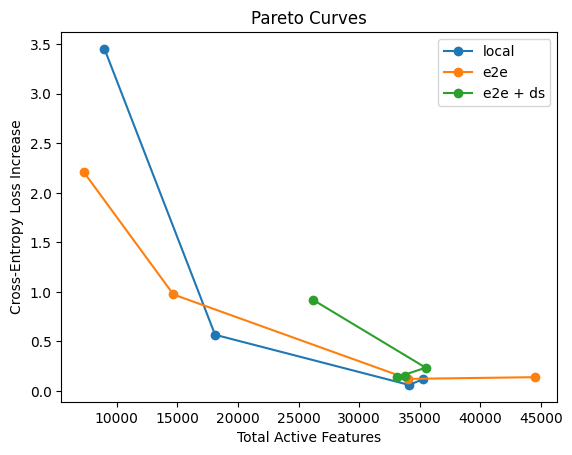

In [ ]:
plots.plot_pareto_curves("gpt2", SAEParams(6, 60 * 768, None), train_loader, val_loader, device="cuda")

In [ ]:
from sae.training.train import train

model_local = train("gpt2", SAEParams(6, 60 * 768, "local"), train_loader, n_epochs=1, sparsity_weight=10e-4)
model_ds = train("gpt2", SAEParams(6, 60 * 768, "e2e + ds"), train_loader, n_epochs=1, sparsity_weight=10e-2)
model_e2e = train("gpt2", SAEParams(6, 60 * 768, "e2e"), train_loader, n_epochs=1, sparsity_weight=10e-2)

epoch 1: 100%|██████████| 2429/2429 [14:41<00:00,  2.76it/s]


In [ ]:
from sae.eval.active_features import eval_l0_and_active_features
from sae.eval.ce_loss import eval_ce_loss_increase
from sae.eval.plots import plot_cosine_similarity, plot_self_similarity

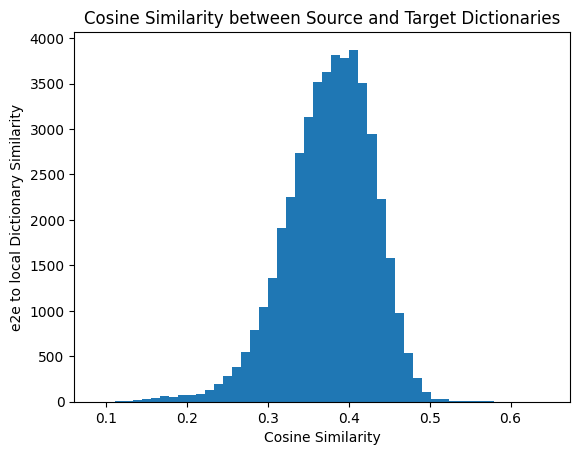

In [ ]:
plot_cosine_similarity("e2e", "local", model_e2e.transformer.sae.encoder.weight.data, model_local.transformer.sae.encoder.weight.data)

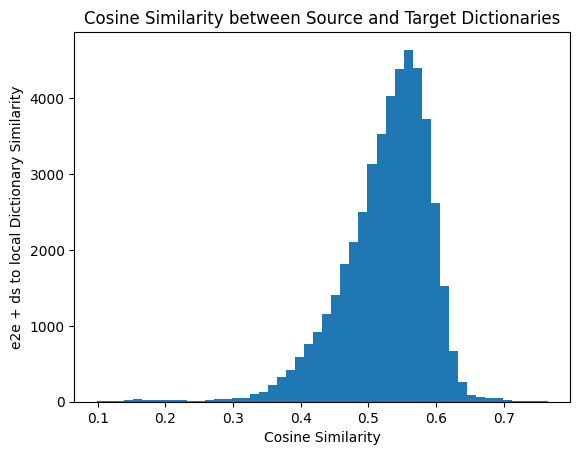

In [ ]:
plot_cosine_similarity("e2e + ds", "local", model_ds.transformer.sae.encoder.weight.data, model_local.transformer.sae.encoder.weight.data)

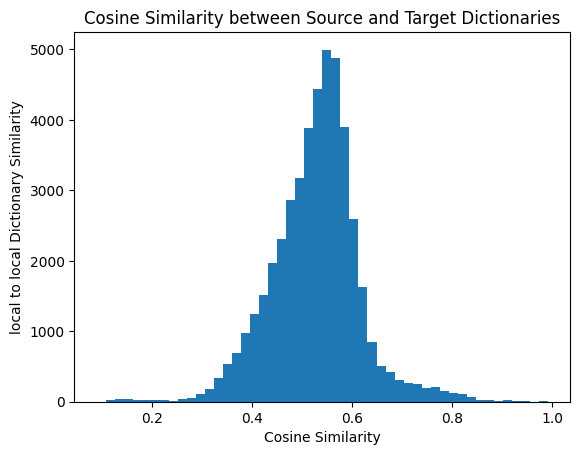

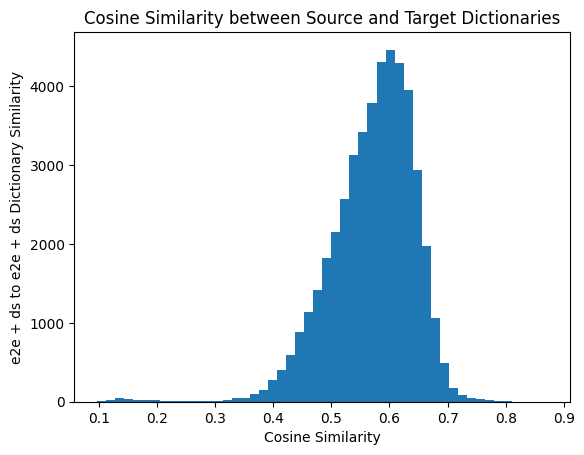

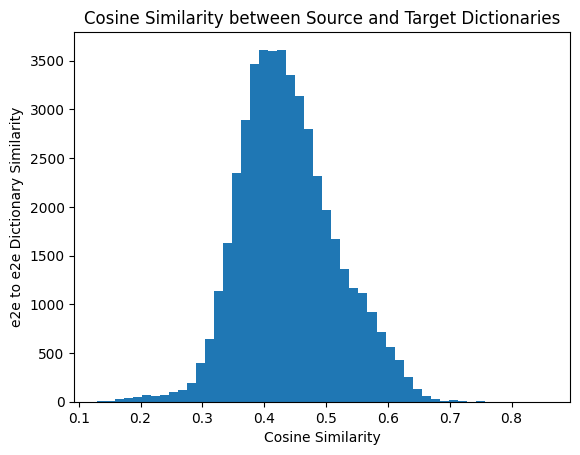

In [ ]:
plot_self_similarity("local", model_local.transformer.sae.encoder.weight.data)
plot_self_similarity("e2e + ds", model_ds.transformer.sae.encoder.weight.data)
plot_self_similarity("e2e", model_e2e.transformer.sae.encoder.weight.data)

In [ ]:
eval_l0_and_active_features(model_ds, val_loader, "cuda")

(96.44482560460028, 32925)

In [ ]:
from sae.models import get_model, SAEParams
normal_model = get_model("gpt2", SAEParams())[0]
eval_ce_loss_increase(normal_model.cuda(), model_ds, val_loader, "cuda")


{'ce_loss_increase': 0.17694708053639394,
 'ce_original': 2.351340253283195,
 'ce_sae': 2.5282873338195886}

### Testing on openwebtext

In [7]:
train_loader_owt, val_loader_owt = get_openwebtext_dataloaders(OpenWebTextConfig(), 4, dataset_name="Elriggs/openwebtext-100k")

README.md:   0%|          | 0.00/366 [00:00<?, ?B/s]

data/train-00000-of-00001-10a4de027237ea(…):   0%|          | 0.00/303M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1217 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3473 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
model_ds_owt = train("gpt2", SAEParams(6, 60 * 768, "e2e + ds"), train_loader_owt, n_epochs=1, sparsity_weight=10e-2)


epoch 1:  19%|█▉        | 2430/12468 [16:17<1:07:19,  2.49it/s]


In [8]:
val_loader_owt_small = [x for x, _ in zip(val_loader_owt, val_loader)]

In [ ]:
eval_l0_and_active_features(model_ds_owt, val_loader_owt_small, "cuda")

(114.4068442290684, 40811)

In [ ]:
eval_ce_loss_increase(normal_model.cuda(), model_ds_owt, val_loader_owt_small, "cuda")

{'ce_loss_increase': 0.8548106814330478,
 'ce_original': 3.1033988797439718,
 'ce_sae': 3.958209564101021}

In [9]:
train_loader_owt_small = [x for x, _ in zip(train_loader_owt, train_loader)]

epoch 1: 100%|██████████| 2429/2429 [17:08<00:00,  2.36it/s]


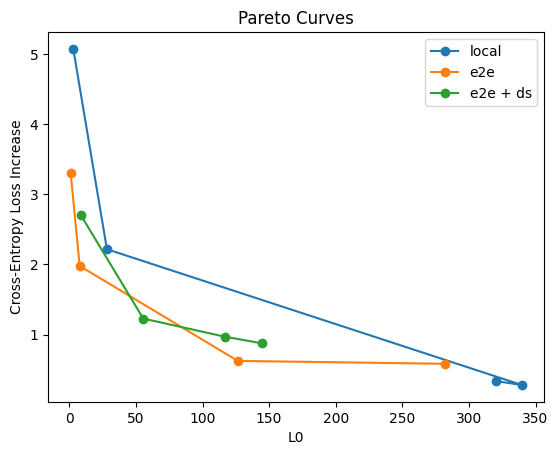

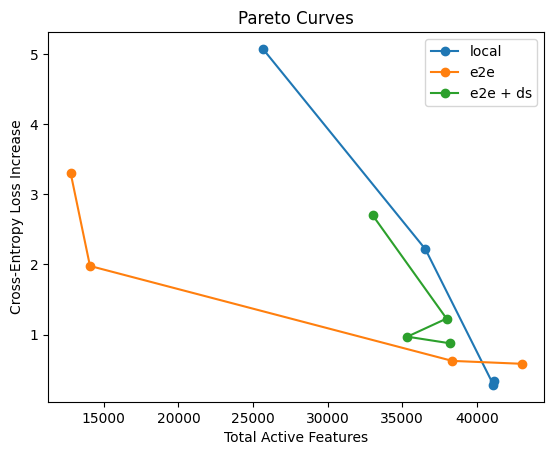

In [10]:
plots.plot_pareto_curves("gpt2", SAEParams(6, 60 * 768, None), train_loader_owt_small, val_loader_owt_small, device="cuda")